In [ ]:
!pip install praw
import praw

In [ ]:
import requests
import time
import json
import datetime as dt
import pandas as pd

from google.colab import files
from google.colab import drive

import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import nltk
nltk.download(['vader_lexicon', 'punkt', 'stopwords', 'wordnet', 'omw-1.4'])
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Useful constants

Both seasons aired in South Korea every Thursday for ten weeks at 21:20 KST (20:20 SGT), and ended roughly at 23:59 KST (22:59 SGT).

The end time is set to one week after the true ending dates of the respective seasons to collect comments from the passing week.

Times have been converted to UTC with the tz argument for ease of scraping.

In [ ]:
Q1_START = int(dt.datetime(2019, 8, 29, 20, 20, 0, tzinfo=dt.timezone(dt.timedelta(hours=8))).timestamp())
Q1_END = int(dt.datetime(2019, 11, 7, 22, 59, 59, tzinfo=dt.timezone(dt.timedelta(hours=8))).timestamp()) # one week after 31/10/19

Q2_START = int(dt.datetime(2022, 3, 31, 20, 20, 0, tzinfo=dt.timezone(dt.timedelta(hours=8))).timestamp())
Q2_END = int(dt.datetime(2022, 6, 9, 22, 59, 59, tzinfo=dt.timezone(dt.timedelta(hours=8))).timestamp()) # one week after 2/6/19

# Scraping Reddit comments

In [ ]:
# check_for_async needed to eliminate false warning in Google Colab

reddit = praw.Reddit(client_id='HIDDEN', client_secret='HIDDEN', \
                     user_agent='Queendom Sentiment Analysis', check_for_async=False)

In [ ]:
def get_submissions(size, start_time, end_time, subreddit, term):
    url = 'https://api.pushshift.io/reddit/search/submission/?size=' + str(size) + \
    '&after=' + str(start_time) + '&before=' + str(end_time) + '&subreddit=' + str(subreddit) + '&title=' + str(term)
    time.sleep(1.1)
    r = requests.get(url)
    data = json.loads(r.text)
    submissions = data['data']
    for i in range(len(submissions)):
        submissions[i] = {'created_utc': submissions[i]['created_utc'], \
                          'permalink': submissions[i]['permalink'], 'subreddit': submissions[i]['subreddit']}
    return submissions # list of dictionaries, each dictionary representing a post (submission)

In [ ]:
def get_comment_ids(submission):
    start = 3 + len(submission['subreddit']) + 10
    end = start + 6
    submission_id = submission['permalink'][start:end]
    url = 'https://api.pushshift.io/reddit/submission/comment_ids/' + str(submission_id)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [ ]:
def get_comments(q, end):
    lst = []
    for i in range(len(q)):
        comment_ids = get_comment_ids(q[i])
        for comment_id in comment_ids:
            comment = reddit.comment(id=comment_id)
            comment = {'body': comment.body, 'created_utc': round(comment.created_utc), \
                        'permalink': comment.permalink, 'score': comment.score, 'subreddit': comment.subreddit}
            if comment['created_utc'] < end:
                lst.append(comment)
    return pd.DataFrame(lst)

I used Pushshift to access the submissions about the first season, Queendom, as Reddit's API did not allow me to capture submissions from so long ago (Queendom had aired in 2019).

However, I used PRAW to access the comments, as Pushshift did not capture all the comments available. PRAW also allowed me to capture accurate upvote data, which could be useful for future analysis.

In [ ]:
# Queendom 1

term = 'queendom'
size = 100
subreddit = 'kpop'
q1 = get_submissions(size, Q1_START, Q1_END, subreddit, term)

while get_submissions(1, q1[-1]['created_utc'] + 8*60*60, Q1_END, subreddit, term):
    time.sleep(1.1)
    q1.extend(get_submissions(size, q1[-1]['created_utc'] + 8*60*60, Q1_END, subreddit, term))

q1_df = get_comments(q1, Q1_END)
q1_df = q1_df.sort_values(by=['created_utc'])

I used PRAW to access both submissions and comments about the second season, Queendom 2, as this project was conducted very shortly after its ending in June 2022, meaning that the data was too recent to be available on Pushshift.

In [ ]:
# Queendom 2

lst = []
for submission in reddit.subreddit("kpop").search("queendom", time_filter="year"): # not case sensitive
    submission = reddit.submission(submission.id)
    if Q2_START <= submission.created_utc + 8*60*60 < Q2_END:
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            comment = {'body': comment.body, 'created_utc': round(comment.created_utc), \
                       'permalink': comment.permalink, 'score': comment.score, 'subreddit': comment.subreddit}
            if comment['created_utc'] < Q2_END:
                lst.append(comment)

q2_df = pd.DataFrame(lst)
q2_df = q2_df.sort_values(by=['created_utc'])

I saved the data to CSV files, which I later uploaded into Google Drive, for quick access during analysis.

In [ ]:
q1_df.to_csv('q1_df.csv', index=False) 
files.download('q1_df.csv')

q2_df.to_csv('q2_df.csv', index=False) 
files.download('q2_df.csv')

# Cleaning the data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
q1_path = '/content/drive/MyDrive/Colab Notebooks/q1_df.csv'
q1_df = pd.read_csv(q1_path)

q2_path = '/content/drive/MyDrive/Colab Notebooks/q2_df.csv'
q2_df = pd.read_csv(q2_path)

In [ ]:
q1_copy = q1_df.copy()
q2_copy = q2_df.copy()

I was unable to remove Reddit quotes, denoted by "> [...] \n\n" in the data, because they were impossible to distinguish from soneone using ">" as a comparator and happening to also have two newlines afterwards. However, the effect of repeated comments (one original and one in a quote) ought to be negligible, as only 85 comments contained text with this "> [...] \n\n" structure.

Asterisks, used for italics, bullet points, and bolding text, do not affect VADER, so they were not removed.

In [ ]:
def clean_data(df):
    remove_contained = ["thank you for submitting", "automatically removed"]
    for item in remove_contained:
        df.drop(df[df['body'].str.contains(item, case=False)].index, inplace=True)
    remove_equals = ["[deleted]", "[removed]"]
    for item in remove_equals:
        df.drop(df[df['body'] == item].index, inplace=True)
    replace = [re.compile('(\(|)http.*?(\)|$|\s)'), '>!', '!<', '\n', '\t', \
               re.compile('!(\[img\]|\[gif\])\((emote|giphy).*?\)'), '&#x200B;', '&nbsp;']
    for item in replace: # Removing, links, spoiler tags, newlines, tabs, imgs, gifs, invisible characters
        df['body'] = df['body'].str.replace(item, ' ').str.strip()
    df.drop(df[df.duplicated(subset=['body'], keep=False) == True].index, inplace=True) # Removing duplicate comments
    return df

In [ ]:
q1_final = clean_data(q1_copy)
q2_final = clean_data(q2_copy)

To account for comments that already compared the two seasons and thus might skew the sentiment analysis, I removed any Queendom 2 comments that mentioned the first season or its competitors. I also removed its April Fools' posts.

In [ ]:
delete = ["queendom 1", "queendom1", "first queendom", "first season", "last season", "previous season", "1st season", "season 1" \
          "season 1", "season one", "s1", "q1", "qd1", "mamamoo", "aoa", "lovelyz", "park bom", "\(g\)i-dle", "idle", "oh my girl"]

for item in delete:
    q2_final.drop(q2_final[q2_final['body'].str.contains(item, case=False)].index, inplace=True)

# regex needed for "mmm" (Mamamoo) and "bom" (Park Bom) to avoid removing common words like "hmmm" or "bomb"
# references to"OMG" (Oh My Girl) hard to remove even with regex; left untouched
q2_final.drop(q2_final[q2_final['body'].str.contains(re.compile('[^0-9A-Za-z](MMM|mmm)[^0-9A-Za-z]'), regex=True)].index, inplace=True)
q2_final.drop(q2_final[q2_final['body'].str.contains(re.compile('[^0-9A-Za-z](bom|Bom|BOM)[^0-9A-Za-z]'), regex=True)].index, inplace=True)

# Deleting April Fools' posts
q2_final.drop(q2_final[q2_final['permalink'].str.contains('r/kpop/comments/tt2ha1/mnet_releases_a_live_racoon_into_queendom_2/')].index, inplace=True)
q2_final.drop(q2_final[q2_final['permalink'].str.contains('r/kpop/comments/tt2tjs/mnet_bans_30_of_queendom_2_live_audience_as_they/')].index, inplace=True)

I was worried that terms associated with positive sentiments in K-pop might be associated with negative sentiments instead due to their common meaning in other spheres. However, their presence and thus effect seemed to be negligible.

In [ ]:
print(len(q1_final))
print(len(q2_final))

# e.g. "Her vocals just keep getting better; she's becoming my new bias!" ("Favourite member" equivalent)
print(len(q1_final.loc[q1_final['body'].str.contains('bias', case=False)])) # 60 out of 3561 comments; 1.68% (2.d.p.)
print(len(q2_final.loc[q2_final['body'].str.contains('bias', case=False)])) # 52 out of 4257 comments; 1.22% (2.d.p.)

# e.g. "Fighting!" ("Jiayou!", "You got this!" equivalent)
print(len(q1_final.loc[q1_final['body'].str.contains('fighting', case=False)])) # 11 out of 3561 comments; 0.31% (2.d.p.)
print(len(q2_final.loc[q2_final['body'].str.contains('fighting', case=False)])) # 18 out of 4257 comments; 0.42% (2.d.p.)

# e.g. "She killed that performance!" ("She did so well!", "She smashed it!" equivalent)
print(len(q1_final.loc[q1_final['body'].str.contains('kill', case=False)])) # 108 out of 3561 comments; 3.03% (2.d.p.)
print(len(q2_final.loc[q2_final['body'].str.contains('kill', case=False)])) # 103 out of 4257 comments; 2.42% (2.d.p.)

# Sentiment analysis

I opted to use VADER over HuggingFace's transformers pipeline as I appreciated its 'NEUTRAL' label that could add nuance. Additionally, VADER's sentiment analysis seemed to match my own human labelling of the comments more closely.

In [ ]:
def tokenized_sentiment_analysis(df):
    # breaking paragraph into sentence tokens, then averaging results for paragraph
    new = df.copy()
    lst = []
    for body in df['body']:
        sentence_list = tokenize.sent_tokenize(body)
        body_sentiments = 0.0
        for sentence in sentence_list:
            body_sentiments += sia.polarity_scores(sentence)['compound']
        if len(sentence_list) > 0:
            lst.append(round(body_sentiments/len(sentence_list), 4))
        else:
            lst.append(round(body_sentiments))
    new['tokenized_compound'] = lst
    new['tokenized_label'] = ['POSITIVE' if v >= 0.05 else 'NEGATIVE' if v <= -0.05 else 'NEUTRAL' for v in new['tokenized_compound']]
    return new

In [ ]:
sia = SentimentIntensityAnalyzer()
q1_labelled = tokenized_sentiment_analysis(q1_final)
q2_labelled = tokenized_sentiment_analysis(q2_final)

# Data visualisation

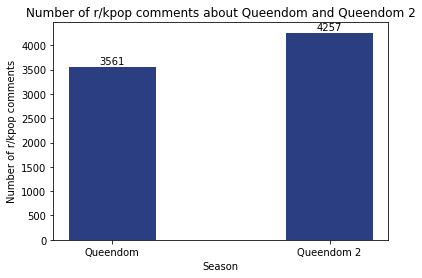

In [ ]:
# Number of comments for each season

fig, ax = plt.subplots()
ax.bar(['Queendom', 'Queendom 2'], [len(q1_labelled), len(q2_labelled)], color='#2b3e81', width=0.4)
ax.set_xlabel("Season")
ax.set_ylabel("Number of r/kpop comments")
ax.set_title("Number of r/kpop comments about Queendom and Queendom 2")
ax.text(0, len(q1_labelled)+50, len(q1_labelled), ha='center')
ax.text(1, len(q2_labelled)+50, len(q2_labelled), ha='center')
plt.show()

The above graph shows that Queendom 2 actually gained more traction than Queendom. Yet, this is likely to have been influenced by the growth of the r/kpop subreddit (and of K-pop's popularity over the intervening three years). In August 2019, when Queendom aired, r/kpop had 400k subscribers; by the time Queendom 2 began to air, this number had risen to 1.3 million.

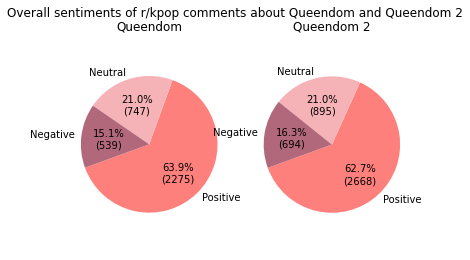

In [ ]:
# Overall sentiments

fig = plt.figure()
q1_ax = fig.add_subplot(121) # one row (1), two columns (2), q1_ax as first subplot (1)
q1_ax.set_title('Queendom')
q2_ax = fig.add_subplot(122)
q2_ax.set_title('Queendom 2')
plt.suptitle("Overall sentiments of r/kpop comments about Queendom and Queendom 2")

labels = ['Positive', 'Neutral', 'Negative']

def pos_neut_neg(q):
  pos = q.loc[q.tokenized_label == 'POSITIVE', 'tokenized_label'].count()
  neut = q.loc[q.tokenized_label == 'NEUTRAL', 'tokenized_label'].count()
  neg = q.loc[q.tokenized_label == 'NEGATIVE', 'tokenized_label'].count()
  return [pos, neut, neg]

def frmt(df, x):
    return '{:.1f}%\n({:.0f})'.format(x, len(df)*x/100)

colors=['#FD807C', '#F6B3B7', '#B2687B']

def pie_chart(df, ax):
  ax.pie(pos_neut_neg(df), labels=labels, colors=colors, autopct=lambda x: frmt(df, x), startangle=200)
  ax.axis('equal') # ensures that pie is drawn as a circle

pie_chart(q1_labelled, q1_ax)
pie_chart(q2_labelled, q2_ax)

plt.show()

It seems that unlike what the claims on Reddit suggested, the proportions of positive, neutral, and negative sentiments were largely similar across both seasons. The proportion of comments assessed to have positive sentiments only dropped by 1.2%.

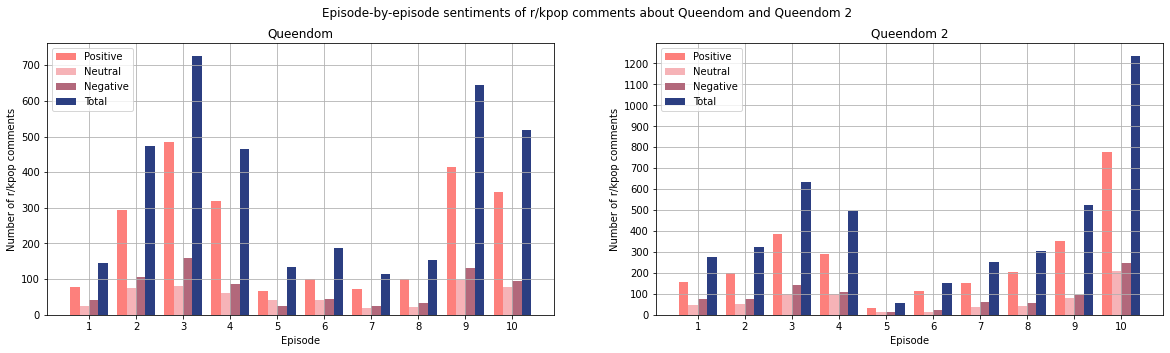

In [ ]:
# Sentiments episode-by-episode

fig = plt.figure(figsize=(20,5))
q1_ax = fig.add_subplot(121)
q2_ax = fig.add_subplot(122)
plt.suptitle("Episode-by-episode sentiments of r/kpop comments about Queendom and Queendom 2")
q1_ax.set_title('Queendom')
q2_ax.set_title('Queendom 2')
q1_ax.set_xlabel("Episode")
q1_ax.set_ylabel("Number of r/kpop comments")
q2_ax.set_xlabel("Episode")
q2_ax.set_ylabel("Number of r/kpop comments")

def week_by_week(df, ax, df_start):
    episodes = list(range(1, 11)) # 10 episodes per season
    x = np.arange(1, 11)
    width = 0.2
    total = []
    pos = []
    neg = []
    neut = []
    a, b = df_start, df_start + 7*24*60*60
    for i in range(1, 11):
        total.append(df.loc[(a <= df.created_utc) & (df.created_utc < b), 'tokenized_label'].count())
        pos.append(df.loc[(a <= df.created_utc) & (df.created_utc < b) & (df.tokenized_label == 'POSITIVE'), 'tokenized_label'].count())
        neg.append(df.loc[(a <= df.created_utc) & (df.created_utc < b) & (df.tokenized_label == 'NEGATIVE'), 'tokenized_label'].count())
        neut.append(df.loc[(a <= df.created_utc) & (df.created_utc < b) & (df.tokenized_label == 'NEUTRAL'), 'tokenized_label'].count())
        a, b = b, b + 7*24*60*60

    ax.bar(x - (1.5 * width), pos, width, label='Positive', color='#FD807C')
    ax.bar(x - (0.5 * width), neg, width, label='Neutral', color='#F6B3B7')
    ax.bar(x + (0.5 * width), neut, width, label='Negative', color='#B2687B')
    ax.bar(x + (1.5 * width), total, width, label='Total', color='#2B3E81')

    ax.xaxis.set_ticks(np.arange(1, 11))
    loc = ticker.MultipleLocator(base=100) # puts ticks at regular intervals of 100
    ax.yaxis.set_major_locator(loc)
    ax.legend()
    ax.grid()

week_by_week(q1_labelled, q1_ax, Q1_START)
week_by_week(q2_labelled, q2_ax, Q2_START)
plt.show()

From these graphs, we observe the following:

1.   Positive sentiments dominated the comments in both seasons for all episodes.
2.   In both seasons, the number of comments rose steadily till Episode 3, then dipped before rising again. However, interestingly, the number of comments left about Queendom during its airing does not peak in the final episode as one might expect; it peaks in Episode 3 instead. This peak may have been due to one of the performances aired during that episode going viral for its social commentary on gender and use of drag queens as backup dancers, leading to greater interest.
3. Even though Queendom 2 had more comments overall, it faced a drastic drop in comments at Episiode 5, where fewer than 100 comments were posted. This dip may have been due to the episode being a "filler" episode, with more behind-the-scenes footage and fewer performances that might have made it less entertaining to watch. Despite having fewer comments overall, Queendom did not ever have such few comments left for an episode.

In [ ]:
def tf_idf(season):
    # used to lemmatise verbs in each comment
    lem = WordNetLemmatizer()
    if season == None:
        q1_text = " ".join(lem.lemmatize(w, pos='v') for body in q1_final['body'] for w in body.split())
        q2_text = " ".join(lem.lemmatize(w, pos='v') for body in q2_final['body'] for w in body.split())
        corpus = [q1_text, q2_text]
        colnames = ['queendom', 'queendom 2']
        vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,2), max_df = 0.5, min_df = 0.5)
        # setting both max_df and min_df to 0.5 means that each word cloud would only contain words unique to each season
    else:
        if season == 'q1':
            a, b = Q1_START, Q1_START + 7*24*60*60
            df_final = q1_final
        if season == 'q2':
            a, b = Q2_START, Q2_START + 7*24*60*60
            df_final = q2_final
        corpus = []
        colnames = []
        for i in range(1, 11):
            subset = df_final.loc[(a <= df_final['created_utc']) & (df_final['created_utc'] < b)]
            text = " ".join(lem.lemmatize(w, pos='v') for body in subset['body'] for w in body.split())
            corpus.append(text)
            colnames.append('episode ' + str(i))
            a, b = b, b + 7*24*60*60
        vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,2), max_df = 0.8, min_df = 0.2)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    df = df.transpose()
    df.columns = colnames
    return df

In [ ]:
# creating custom colormap with queendom theme colours

rgb_2b3e81 = (43, 62, 129)
rgb_fd807c = (253, 128, 124)
colors = [tuple(map(lambda x: x/255, rgb_2b3e81)), tuple(map(lambda x: x/255, rgb_fd807c))] # divided by 255 to normalise
cmap = LinearSegmentedColormap.from_list('queendom_colours', colors)

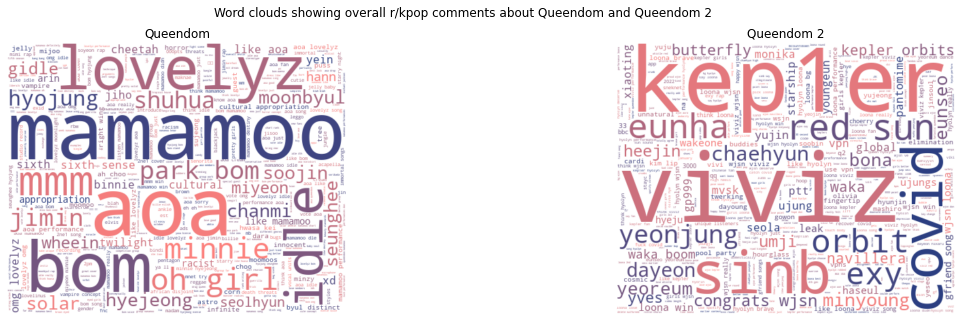

In [ ]:
overall_wc = tf_idf(None)
cols = list(overall_wc.columns)

fig = plt.figure(figsize=[20,5])
plt.suptitle("Word clouds showing overall r/kpop comments about Queendom and Queendom 2")

for i in range(len(cols)):
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(cols[i].capitalize())
    wordcloud = WordCloud(background_color="white", width=500, height=400, max_words=400, colormap=cmap).generate_from_frequencies(overall_wc[cols[i]])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

plt.show()

The word cloud mainly contains the names of the groups and group members for each season, and reveals the most talked-about performers for each season.

The following two code blocks produce word clouds that lend insight into the highlights of each episode for each season.

The reliability of the word cloud was limited by the lemmatiser, which was unable to correctly lemmatise all the words in the comments. For instance, 'felt', the past tense of 'feel', seems to have been interpreted as a noun and left as 'felt'. 'rating', on the other hand, was lemmatised as 'rat' rather than 'rate'.

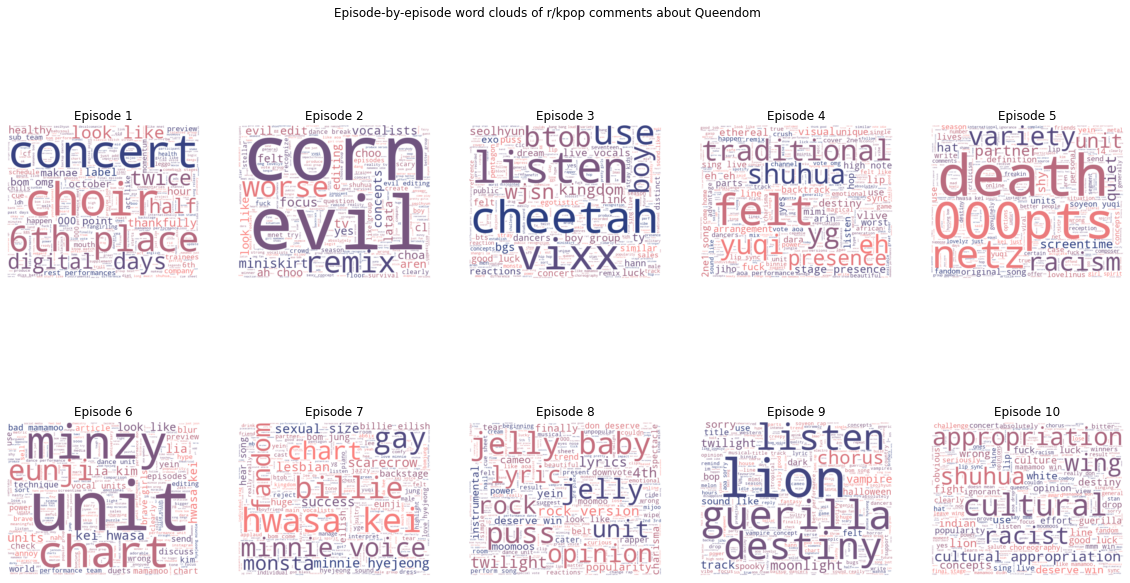

In [ ]:
# Q1 word clouds episode-by-episode

q1_wc = tf_idf('q1')
cols = list(q1_wc.columns)

fig = plt.figure(figsize=[20,10])
plt.suptitle("Episode-by-episode word clouds of r/kpop comments about Queendom")

for i in range(len(cols)):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title(cols[i].capitalize())
    wordcloud = WordCloud(background_color="white", width=500, height=400, max_words=400, colormap=cmap).generate_from_frequencies(q1_wc[cols[i]])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

plt.show()

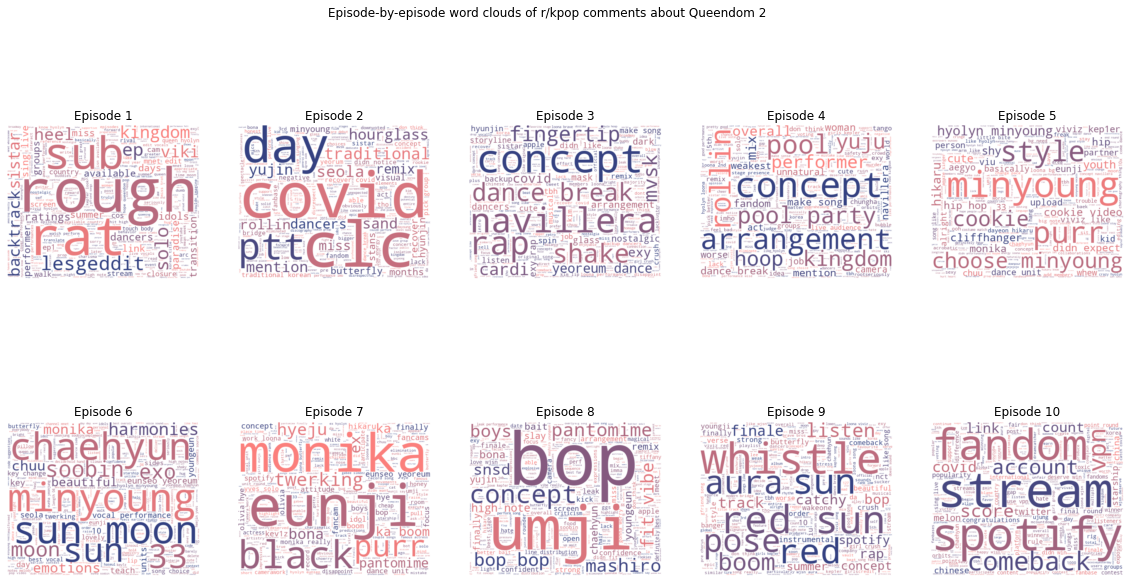

In [ ]:
# Q2 word clouds episode-by-episode

q2_wc = tf_idf('q2')
cols = list(q2_wc.columns)

fig = plt.figure(figsize=[20,10])
plt.suptitle("Episode-by-episode word clouds of r/kpop comments about Queendom 2")

for i in range(len(cols)):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title(cols[i].capitalize())
    wordcloud = WordCloud(background_color="white", width=500, height=400, max_words=400, colormap=cmap).generate_from_frequencies(q2_wc[cols[i]])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

plt.show()